<a href="https://colab.research.google.com/github/ahataha123/Image-Classification/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Street View House Numbers Classification

The SVHN (Street View House Numbers) dataset, a widely recognized standard for object recognition studies in academic research, consists of images derived from house numbers captured in Google Street View. Hosted by Stanford University, it shares conceptual similarities with the MNIST dataset. The primary challenge it addresses is the more complex task of identifying digits and numbers within images of natural scenes.


The Street View House Numbers (SVHN) dataset, accessible here, is initially provided in .mat format, typically associated with MATLAB. Consequently, preprocessing is essential (refer to section 2 for details). Notably, the dataset is segmented into two distinct formats. In this specific analysis, we will focus on the cropped digits format, which consists of 32x32 pixel images. These images resemble the MNIST dataset's style but also include additional, potentially distracting digits adjacent to the primary digit of interest.

Documentation:

SVHN: http://ufldl.stanford.edu/housenumbers/

## 1. Imports

In [ ]:
import numpy as np
import keras
import seaborn as sns
import os
import scipy.io
from matplotlib import pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

## 2. Loading and preprocessing

In [ ]:
!unzip '/content/drive/MyDrive/Data/test_32x32.mat.zip'
!unzip '/content/drive/MyDrive/Data/train_32x32.mat.zip'

unzip:  cannot find or open /content/drive/MyDrive/Data/test_32x32.mat.zip, /content/drive/MyDrive/Data/test_32x32.mat.zip.zip or /content/drive/MyDrive/Data/test_32x32.mat.zip.ZIP.
unzip:  cannot find or open /content/drive/MyDrive/Data/train_32x32.mat.zip, /content/drive/MyDrive/Data/train_32x32.mat.zip.zip or /content/drive/MyDrive/Data/train_32x32.mat.zip.ZIP.


In [ ]:
train_data = loadmat('/content/train_32x32.mat')
test_data = loadmat('/content/test_32x32.mat')

In [ ]:
# Load images and labels
# Fix the shape of train and test images
# Fix the image format
train_images = np.transpose(train_data['X'], (3, 0, 1, 2))
test_images = np.transpose(test_data['X'], (3, 0, 1, 2))
train_labels = train_data['y']
test_labels = test_data['y']

# Confirm shape
print(train_images.shape)  # should be (73257, 32, 32, 3)
print(train_labels.shape)  # should be (73257, 10)

(73257, 32, 32, 3)
(73257, 1)


In [ ]:
train_data = scipy.io.loadmat('/content/train_32x32.mat')
test_data = scipy.io.loadmat('/content/test_32x32.mat')

# Print available keys
print("Train data keys:", train_data.keys())
print("Test data keys:", test_data.keys())

Train data keys: dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
Test data keys: dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])


In [ ]:
# Check the shape of the data

print(train_images.shape)
print(test_images.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


In [ ]:
# Convert train and test images into 'float64' type

train_images = train_images.astype('float64')
test_images = test_images.astype('float64')

In [ ]:
# Convert train and test labels into 'int64' type

train_labels = train_labels.astype('int64')
test_labels = test_labels.astype('int64')

train_labels = train_data['y'].flatten()
test_labels = test_data['y'].flatten()


In [ ]:
# Normalize the images data

print('Min: {}, Max: {}'.format(train_images.min(), train_images.max()))

train_images /= 255.0
test_images /= 255.0

Min: 0.0, Max: 255.0


In [ ]:
# One-hot encoding of train and test labels

lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.fit_transform(test_labels)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, test_size=0.15, random_state=22
)

In [ ]:
y_val.shape

(10989, 10)

## 3. Convolutional Neural Network for Classification

**Data Augmentation**

To enhance the size and quality of training dataset, we achieve this by applying a series of random transformations to the original training data. This is called Data Augmentation.
To enhance the robustness of our model, we plan to augment the images in our dataset through various transformations. These include random rotations, zooming in and out, and vertical shifting. Horizontal shifting is not used due to the presence of distracting digits in the images.


In [ ]:
# Data augmentation

data_augmentation = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.10,
                             shear_range=0.15)

We used an auxillary model as a second model to assist in achieving even better accuracy, as seen in the code below.

In [ ]:
# Auxillary model

keras.backend.clear_session()

auxillary_model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same',activation='relu',input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same',activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(10,  activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


The code snippet is for training an auxiliary neural network model, designated as aux_model, using a specialized training approach. It employs the fit method to train the model, where the training data, consisting of features X_train and labels y_train, is augmented on-the-fly using the auxillary_model instance of ImageDataGenerator. This augmentation includes transformations like rotation, shifting, and shearing, applied in batches of 256 images each. The training process is set to run for 30 epochs, allowing the model to learn from the augmented data iteratively. Alongside, the model's performance is validated using a separate validation dataset comprised of X_val (validation features) and y_val (validation labels), providing insights into how well the model generalizes to new data. Additionally, the training employs a dynamic learning rate adjustment mechanism through the learning_rate_schedule callback, which modifies the learning rate during the training process based on predefined criteria or the model's performance, aiding in more effective learning and potentially faster convergence. This combination of data augmentation, validation, and adaptive learning rate scheduling aims to enhance the model's ability to learn robustly from the data and generalize well to unseen data.

In [ ]:
learning_rate_schedule = keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
optimizer = keras.optimizers.Adam(learning_rate=1e-4, amsgrad=True)
auxillary_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                 metrics=["Accuracy","Recall","Precision"])

In [ ]:
# Fit model in order to determine best learning rate


history =auxillary_model.fit(data_augmentation.flow(X_train, y_train, batch_size=256),
                              epochs=30, validation_data=(X_val, y_val),
                              callbacks=[learning_rate_schedule])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 62s 197ms/step - Accuracy: 0.1421 - Precision: 0.1444 - Recall: 0.0094 - loss: 2.5120 - val_Accuracy: 0.1947 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 2.2514 - learning_rate: 1.0000e-04
Epoch 2/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 37s 152ms/step - Accuracy: 0.1834 - Precision: 0.5204 - Recall: 0.0040 - loss: 2.2388 - val_Accuracy: 0.2012 - val_Precision: 1.0000 - val_Recall: 0.0012 - val_loss: 2.1311 - learning_rate: 1.2589e-04
Epoch 3/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 37s 152ms/step - Accuracy: 0.3742 - Precision: 0.7561 - Recall: 0.1609 - loss: 1.8098 - val_Accuracy: 0.7230 - val_Precision: 0.9304 - val_Recall: 0.5301 - val_loss: 0.8811 - learning_rate: 1.5849e-04
Epoch 4/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 37s 151ms/step - Accuracy: 0.6222 - Precision: 0.8020 - Recall: 0.4699 - loss: 1.1357 - val_Accuracy: 0.8284 - val_Precision: 0.9233 - val_Recall: 0.7453 - val_loss: 0.5620 - learning_rate: 1.9953e-04
Epoch 5/30
244/244 ━━━━━━━━━

The Code Snippet shows the main model, we used for classifying our dataset. As you can see, we have used various methods such as Conv2D, Dense, BatchNormalization, MaxPooling, Dropout,
Flatten and etc for our CNN. We used the framework keras for this model. We experimented with different layers and the number of layers until we were able to reach the maximum accuracy as possible.

In [ ]:
# Define actual model

keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu',input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(10,  activation='softmax')
])


Here you can see, the summary of our model's layers

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 551,466 (2.10 MB)

 Trainable params: 551,018 (2.10 MB)

 Non-trainable params: 448 (1.75 KB)

We used the compile and fit methods to fit and train our model.
We used CategoricalCrossentropy as a loss function, Adam as a optimizer and tracked Accuracy, Recall, Loss, and Precision while training the model.

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=8)
optimizer = keras.optimizers.Adam(learning_rate=1e-3, amsgrad=True)
model_checkpoint = keras.callbacks.ModelCheckpoint('/content/best_cnn.h5', save_best_only=True)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["Accuracy","Recall","Precision"])


In [ ]:
# Fit model in order to make predictions


history = model.fit(data_augmentation.flow(X_train, y_train, batch_size=128),
                              epochs=30, validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - Accuracy: 0.1780 - Precision: 0.3806 - Recall: 0.0150 - loss: 2.3230

487/487 ━━━━━━━━━━━━━━━━━━━━ 60s 98ms/step - Accuracy: 0.1781 - Precision: 0.3813 - Recall: 0.0151 - loss: 2.3227 - val_Accuracy: 0.3997 - val_Precision: 0.9626 - val_Recall: 0.1639 - val_loss: 1.6733
Epoch 2/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - Accuracy: 0.4151 - Precision: 0.7789 - Recall: 0.2532 - loss: 1.6094

487/487 ━━━━━━━━━━━━━━━━━━━━ 40s 82ms/step - Accuracy: 0.4152 - Precision: 0.7789 - Recall: 0.2533 - loss: 1.6091 - val_Accuracy: 0.8110 - val_Precision: 0.9512 - val_Recall: 0.6231 - val_loss: 0.6839
Epoch 3/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - Accuracy: 0.6792 - Precision: 0.8467 - Recall: 0.5594 - loss: 0.9378

487/487 ━━━━━━━━━━━━━━━━━━━━ 40s 82ms/step - Accuracy: 0.6793 - Precision: 0.8468 - Recall: 0.5595 - loss: 0.9375 - val_Accuracy: 0.8725 - val_Precision: 0.9447 - val_Recall: 0.8093 - val_loss: 0.4344
Epoch 4/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - Accuracy: 0.8413 - Precision: 0.9115 - Recall: 0.7833 - loss: 0.5343

487/487 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - Accuracy: 0.8413 - Precision: 0.9115 - Recall: 0.7834 - loss: 0.5342 - val_Accuracy: 0.9148 - val_Precision: 0.9472 - val_Recall: 0.8924 - val_loss: 0.2876
Epoch 5/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - Accuracy: 0.8758 - Precision: 0.9272 - Recall: 0.8321 - loss: 0.4280

487/487 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - Accuracy: 0.8758 - Precision: 0.9272 - Recall: 0.8321 - loss: 0.4280 - val_Accuracy: 0.9285 - val_Precision: 0.9527 - val_Recall: 0.9100 - val_loss: 0.2672
Epoch 6/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - Accuracy: 0.8886 - Precision: 0.9341 - Recall: 0.8530 - loss: 0.3875

487/487 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - Accuracy: 0.8886 - Precision: 0.9342 - Recall: 0.8530 - loss: 0.3875 - val_Accuracy: 0.9304 - val_Precision: 0.9578 - val_Recall: 0.9046 - val_loss: 0.2546
Epoch 7/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - Accuracy: 0.8993 - Precision: 0.9407 - Recall: 0.8630 - loss: 0.3556

487/487 ━━━━━━━━━━━━━━━━━━━━ 40s 82ms/step - Accuracy: 0.8993 - Precision: 0.9407 - Recall: 0.8630 - loss: 0.3556 - val_Accuracy: 0.9374 - val_Precision: 0.9574 - val_Recall: 0.9213 - val_loss: 0.2348
Epoch 8/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - Accuracy: 0.9077 - Precision: 0.9440 - Recall: 0.8767 - loss: 0.3244

487/487 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - Accuracy: 0.9077 - Precision: 0.9440 - Recall: 0.8767 - loss: 0.3244 - val_Accuracy: 0.9399 - val_Precision: 0.9629 - val_Recall: 0.9213 - val_loss: 0.2242
Epoch 9/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 40s 82ms/step - Accuracy: 0.9120 - Precision: 0.9470 - Recall: 0.8834 - loss: 0.3111 - val_Accuracy: 0.9308 - val_Precision: 0.9571 - val_Recall: 0.9085 - val_loss: 0.2489
Epoch 10/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 40s 82ms/step - Accuracy: 0.9165 - Precision: 0.9497 - Recall: 0.8898 - loss: 0.2944 - val_Accuracy: 0.9358 - val_Precision: 0.9595 - val_Recall: 0.9173 - val_loss: 0.2273
Epoch 11/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - Accuracy: 0.9198 - Precision: 0.9527 - Recall: 0.8945 - loss: 0.2783

487/487 ━━━━━━━━━━━━━━━━━━━━ 42s 85ms/step - Accuracy: 0.9198 - Precision: 0.9527 - Recall: 0.8945 - loss: 0.2783 - val_Accuracy: 0.9422 - val_Precision: 0.9600 - val_Recall: 0.9277 - val_loss: 0.2166
Epoch 12/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 40s 82ms/step - Accuracy: 0.9236 - Precision: 0.9527 - Recall: 0.8993 - loss: 0.2692 - val_Accuracy: 0.9353 - val_Precision: 0.9576 - val_Recall: 0.9211 - val_loss: 0.2405
Epoch 13/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - Accuracy: 0.9258 - Precision: 0.9529 - Recall: 0.9013 - loss: 0.2643

487/487 ━━━━━━━━━━━━━━━━━━━━ 41s 84ms/step - Accuracy: 0.9258 - Precision: 0.9529 - Recall: 0.9013 - loss: 0.2643 - val_Accuracy: 0.9465 - val_Precision: 0.9611 - val_Recall: 0.9361 - val_loss: 0.2085
Epoch 14/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - Accuracy: 0.9263 - Precision: 0.9527 - Recall: 0.9036 - loss: 0.2643

487/487 ━━━━━━━━━━━━━━━━━━━━ 41s 84ms/step - Accuracy: 0.9263 - Precision: 0.9527 - Recall: 0.9036 - loss: 0.2643 - val_Accuracy: 0.9485 - val_Precision: 0.9640 - val_Recall: 0.9344 - val_loss: 0.2016
Epoch 15/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 42s 86ms/step - Accuracy: 0.9301 - Precision: 0.9558 - Recall: 0.9096 - loss: 0.2509 - val_Accuracy: 0.9480 - val_Precision: 0.9625 - val_Recall: 0.9384 - val_loss: 0.2064
Epoch 16/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - Accuracy: 0.9286 - Precision: 0.9539 - Recall: 0.9079 - loss: 0.2489

487/487 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - Accuracy: 0.9286 - Precision: 0.9539 - Recall: 0.9079 - loss: 0.2489 - val_Accuracy: 0.9499 - val_Precision: 0.9645 - val_Recall: 0.9399 - val_loss: 0.1960
Epoch 17/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 40s 82ms/step - Accuracy: 0.9334 - Precision: 0.9570 - Recall: 0.9137 - loss: 0.2320 - val_Accuracy: 0.9470 - val_Precision: 0.9623 - val_Recall: 0.9337 - val_loss: 0.2046
Epoch 18/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 40s 82ms/step - Accuracy: 0.9341 - Precision: 0.9575 - Recall: 0.9160 - loss: 0.2225 - val_Accuracy: 0.9479 - val_Precision: 0.9650 - val_Recall: 0.9368 - val_loss: 0.1986
Epoch 19/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 41s 84ms/step - Accuracy: 0.9345 - Precision: 0.9579 - Recall: 0.9151 - loss: 0.2261 - val_Accuracy: 0.9422 - val_Precision: 0.9635 - val_Recall: 0.9285 - val_loss: 0.2128
Epoch 20/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - Accuracy: 0.9386 - Precision: 0.9600 - Recall: 0.9208 - loss: 0.2145

487/487 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - Accuracy: 0.9386 - Precision: 0.9600 - Recall: 0.9208 - loss: 0.2145 - val_Accuracy: 0.9502 - val_Precision: 0.9660 - val_Recall: 0.9380 - val_loss: 0.1957
Epoch 21/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - Accuracy: 0.9385 - Precision: 0.9590 - Recall: 0.9225 - loss: 0.2116 - val_Accuracy: 0.9480 - val_Precision: 0.9646 - val_Recall: 0.9355 - val_loss: 0.2012
Epoch 22/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - Accuracy: 0.9399 - Precision: 0.9602 - Recall: 0.9230 - loss: 0.2101 - val_Accuracy: 0.9514 - val_Precision: 0.9649 - val_Recall: 0.9416 - val_loss: 0.1970
Epoch 23/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - Accuracy: 0.9372 - Precision: 0.9581 - Recall: 0.9210 - loss: 0.2157

487/487 ━━━━━━━━━━━━━━━━━━━━ 42s 86ms/step - Accuracy: 0.9372 - Precision: 0.9581 - Recall: 0.9210 - loss: 0.2157 - val_Accuracy: 0.9542 - val_Precision: 0.9660 - val_Recall: 0.9454 - val_loss: 0.1920
Epoch 24/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - Accuracy: 0.9418 - Precision: 0.9617 - Recall: 0.9255 - loss: 0.1989

487/487 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - Accuracy: 0.9418 - Precision: 0.9617 - Recall: 0.9255 - loss: 0.1990 - val_Accuracy: 0.9524 - val_Precision: 0.9678 - val_Recall: 0.9431 - val_loss: 0.1888
Epoch 25/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 40s 82ms/step - Accuracy: 0.9406 - Precision: 0.9607 - Recall: 0.9247 - loss: 0.1983 - val_Accuracy: 0.9513 - val_Precision: 0.9674 - val_Recall: 0.9411 - val_loss: 0.1935
Epoch 26/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 40s 82ms/step - Accuracy: 0.9417 - Precision: 0.9612 - Recall: 0.9235 - loss: 0.2017 - val_Accuracy: 0.9509 - val_Precision: 0.9652 - val_Recall: 0.9403 - val_loss: 0.1907
Epoch 27/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - Accuracy: 0.9439 - Precision: 0.9630 - Recall: 0.9284 - loss: 0.1883

487/487 ━━━━━━━━━━━━━━━━━━━━ 41s 84ms/step - Accuracy: 0.9439 - Precision: 0.9630 - Recall: 0.9284 - loss: 0.1883 - val_Accuracy: 0.9568 - val_Precision: 0.9683 - val_Recall: 0.9484 - val_loss: 0.1817
Epoch 28/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - Accuracy: 0.9436 - Precision: 0.9626 - Recall: 0.9284 - loss: 0.1896 - val_Accuracy: 0.9535 - val_Precision: 0.9664 - val_Recall: 0.9426 - val_loss: 0.1953
Epoch 29/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - Accuracy: 0.9440 - Precision: 0.9625 - Recall: 0.9296 - loss: 0.1907 - val_Accuracy: 0.9540 - val_Precision: 0.9657 - val_Recall: 0.9458 - val_loss: 0.1912
Epoch 30/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - Accuracy: 0.9469 - Precision: 0.9644 - Recall: 0.9327 - loss: 0.1848 - val_Accuracy: 0.9448 - val_Precision: 0.9608 - val_Recall: 0.9338 - val_loss: 0.2146


In [ ]:
print(history.history.keys())

dict_keys(['Accuracy', 'Precision', 'Recall', 'loss', 'val_Accuracy', 'val_Precision', 'val_Recall', 'val_loss'])


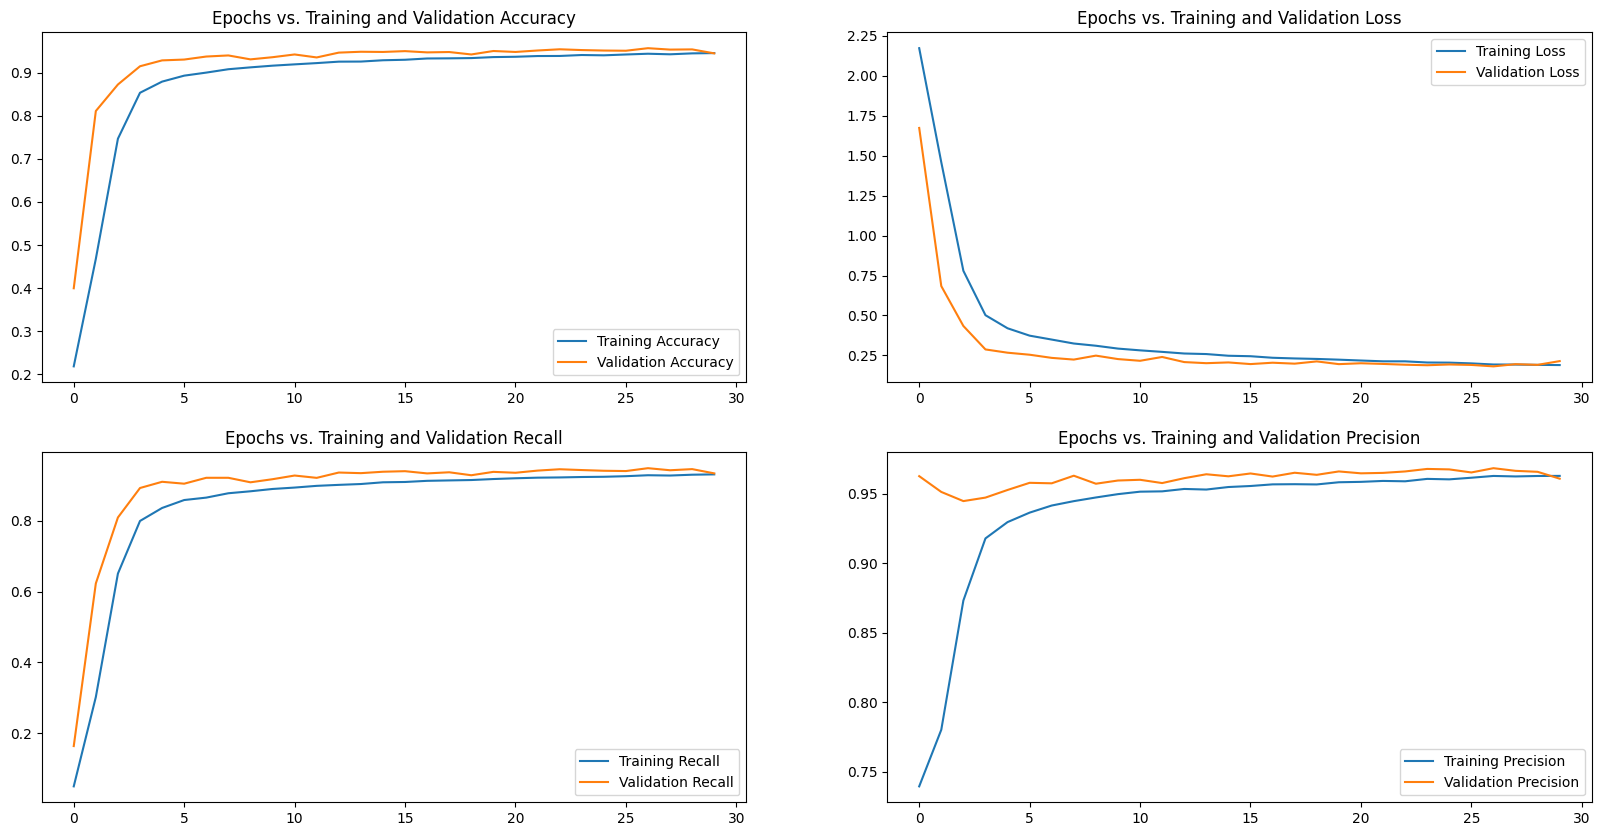

In [ ]:
# Evaluate train and validation accuracies and losses

train_acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_recall = history.history['Recall']
val_recall = history.history['val_Recall']

train_precision = history.history['Precision']
val_precision = history.history['val_Precision']
plt.figure(figsize=(20, 10))

# Visualize epochs vs. train and validation accuracies and losses
# Erster Subplot
plt.subplot(2, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')

# Zweiter Subplot
plt.subplot(2, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')

# Dritter Subplot
plt.subplot(2, 2, 3)
plt.plot(train_recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend()
plt.title('Epochs vs. Training and Validation Recall')

# Vierter Subplot
plt.subplot(2, 2, 4)
plt.plot(train_precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.legend()
plt.title('Epochs vs. Training and Validation Precision')


plt.show()

After seeing how the algorithm converged, we can now evaluate the model's performance on the test data.

In [ ]:
# Evaluate model on test data
test_loss, test_acc, test_precision, test_recall = model.evaluate(x=test_images, y=test_labels, verbose=0)


print('accuracy is: {:0.4f} \nloss is: {:0.4f} \nprecision is: {:0.4f} \nrecall is: {:0.4f}'
.format(test_acc, test_loss, test_precision, test_recall))

accuracy is: 0.9501 
loss is: 0.1971 
precision is: 0.9415 
recall is: 0.9614


## 4. Visualizations of our CNN Model and Results

To gain deeper insights into the workings of a Convolutional Neural Network, it's highly beneficial to visualize certain aspects of the model. Two of the most enlightening visualizations are the Confusion Matrix and Feature Maps.

The Confusion Matrix, when applied to training data, provides a clear view of the model's performance across different class labels, highlighting how misclassifications are distributed among them. This helps in understanding the model's strengths and weaknesses in classifying each category.

On the other hand, visualizing Feature Maps for a random input image can reveal how the model processes and learns features at each convolutional layer. Such visualizations are not just illustrative but also crucial in demystifying the complex operations within the layers of the network, offering a window into the intricate mechanics of how the model interprets and responds to input data.

In [ ]:
# Get predictions and apply inverse transformation to the labels

y_pred = model.predict(X_train)

y_pred = lb.inverse_transform(y_pred, lb.classes_)
y_train = lb.inverse_transform(y_train, lb.classes_)

1946/1946 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


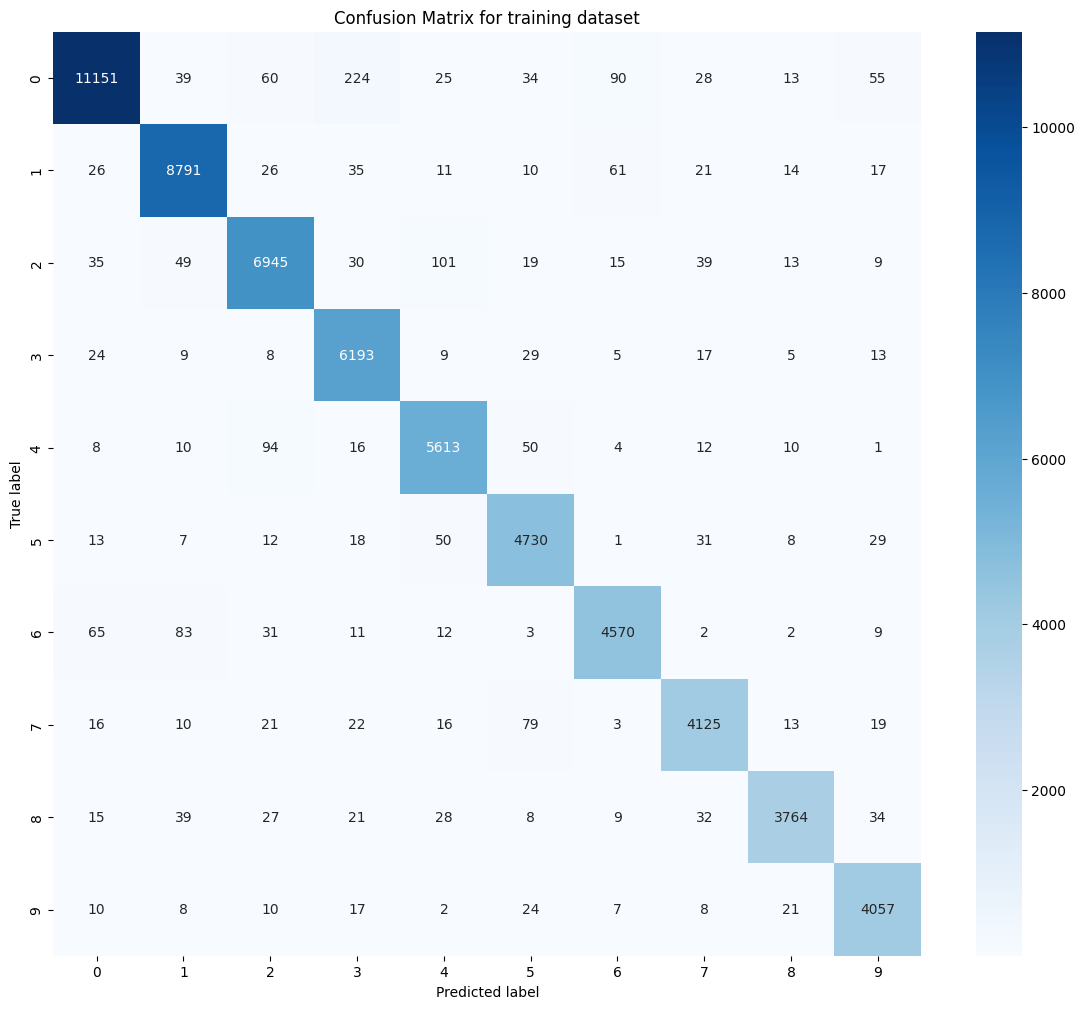

In [ ]:
# Plot the confusion matrix

matrix = confusion_matrix(y_train, y_pred, labels=lb.classes_)

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(matrix, annot=True, cmap='Blues', fmt='d', ax=ax)
plt.title('Confusion Matrix for training dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Observing the training data, it's evident that it predominantly contains the digits 0, 1, and 2, in decreasing order of frequency, with digits 5 through 9 being underrepresented. Additionally, the confusion matrix provides valuable insights into the specific areas where our model faces challenges.

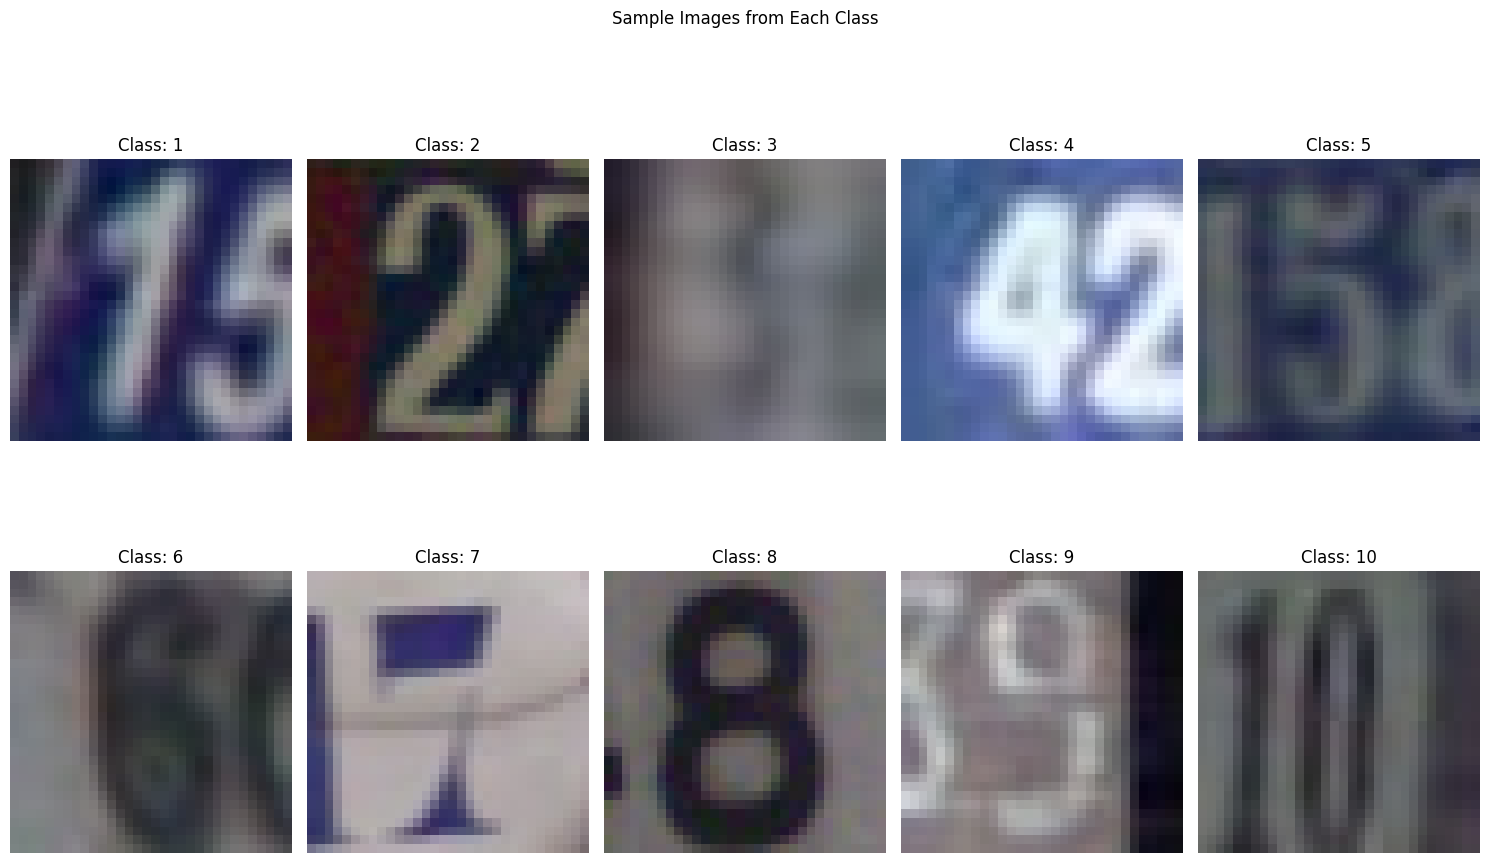

In [ ]:
# Assuming y_train contains numeric class labels and X_train are images
classes = np.unique(y_train)
num_classes = len(classes)

plt.figure(figsize=(15, 10))

for i, label in enumerate(classes):
    # Get first image of this class
    idx = np.where(y_train == label)[0][0]
    img = X_train[idx]

    # Plot
    plt.subplot(2, (num_classes + 1) // 2, i + 1)
    plt.imshow(img.squeeze(), cmap='gray')  # or cmap='viridis', adjust for RGB
    plt.title(f"Class: {label}")
    plt.axis('off')

plt.suptitle("Sample Images from Each Class")
plt.tight_layout()
plt.show()


## 5. Conclusion

In this project, Convolutional Neural Network has been developed to identify digits from the Street View House Numbers dataset. The process involved initial minimal preprocessing of the data, followed by diverse data augmentation techniques. Additionally, an auxiliary model was constructed to determine the optimal learning rate for our optimizer. Ultimately, the final CNN was trained and its performance was assessed on the test image dataset.

In [ ]:
import os
import tensorflow as tf

# Create directory if it doesn't exist
os.makedirs('saved_models', exist_ok=True)

# Save the model
model.save('saved_models/model_with_data_augmentation_layer.keras')

# Load the model
loaded_model = tf.keras.models.load_model('saved_models/model_with_data_augmentation_layer.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 24 variables whereas the saved optimizer has 68 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
